In [1]:
!pip install nltk sacrebleu rouge-score bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=20726c841a24cead3588f9ce9a2406486a7db3cb5a7087b4ebdc692d681cb3af
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    T5Tokenizer,
    T5ForConditionalGeneration
)
from transformers.models.t5.modeling_t5 import T5LayerFF
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import sacrebleu
from rouge_score import rouge_scorer
import bert_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!unzip -qn /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

base_bert_path = "emilyalsentzer/Bio_ClinicalBERT"
base_t5_path = "t5-small"
finetuned_bert_path = (
    "BioClinicalBert-MLM-Finetuned-40k-25epoch-exp-25epoch-questions.pth"
)
finetuned_t5_path = "T5-Finetuned-15k-20epoch.pth"
dataset_file_name = (
    "MEDMCQA-dataset-with-CLS-40k-25epoch-exp-25epoch-questions-nltk.json"
)
repo_id = "alibababeig/nlp-hw4"

batch_size = 32
bottleneck_size = 32
k = 3  # KNN hyperparameter

# Load Fine-tuned BERT Model from Hugging Face

In [4]:
bert_tokenizer = BertTokenizer.from_pretrained(base_bert_path)
bert_model = BertForMaskedLM.from_pretrained(base_bert_path).to(device)

checkpoint_file = hf_hub_download(repo_id=repo_id, filename=finetuned_bert_path)
checkpoint = torch.load(checkpoint_file)
bert_model.load_state_dict(checkpoint["model_state_dict"])
bert_model = bert_model.bert  # dropping MLM head
bert_model.eval()

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(…)ed-40k-25epoch-exp-25epoch-questions.pth:   0%|          | 0.00/433M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Load Pre-processed Dataset from Hugging Face

In [5]:
dataset_path = hf_hub_download(repo_id=repo_id, filename=dataset_file_name)
loaded_df = pd.read_json(dataset_path)
display(loaded_df)

(…)-25epoch-exp-25epoch-questions-nltk.json:   0%|          | 0.00/249M [00:00<?, ?B/s]

,question,exp,question_cls
0,"All of the following are pyrogenic cytokines, ...",Interleukin 18 is not a pyrogenic cytokine. IL...,"[0.549001753330231, -0.12343280017375902, 0.15..."
1,40-year old female presented with neck swellin...,Ref. Robbins Pathology. 9th edition. Page. 109...,"[-0.24133916199207303, 0.097042627632618, -0.2..."
2,Following statement regarding dislocation of t...,Anterior dislocation is more common in which h...,"[-0.386974930763245, -0.131634533405304, 0.241..."
3,The active search for unrecognized disease or ...,Screening is the search for unrecognized disea...,"[-0.091413952410221, -0.04559937492013, -0.082..."
4,Fir tree pattern lesion is seen in,Fir tree pattern of distribution of lesions is...,"[-0.41899171471595803, -0.24402141571044902, -..."
...,...,...,...
16826,Carcinoma sigmoid colon with obstruction Manag...,- Obstruction due to rectosigmoid growth with ...,"[0.241796687245369, 0.7256665825843811, -0.431..."
16827,ADHD in childhood can lead to which of the fol...,"ADHD can lead to substance abuse,mood disorder...","[0.20766235888004303, -0.30834984779357905, 0...."
16828,Nerve for adductor compament of thigh ?,Ans. B) Obturator nerveObturator nerve is the ...,"[0.134738609194756, 0.008813104592264, -0.2542..."
16829,The &;a&;wave of jugular venous pulse is produ...,JVP or jugular venous is a reflection of the r...,"[-0.035813611000776, 0.18877704441547402, -0.1..."


In [6]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)


def encode_text(text, tokenizer, bert_model, max_length=128):
    text = preprocess_text(text)
    tokens = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = bert_model(**tokens)

    if "pooler_output" in outputs:
        cls_embedding = outputs.pooler_output
    elif "last_hidden_state" in outputs:
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    else:
        raise Exception("No CLS token found in the given model")

    return cls_embedding.cpu()

In [7]:
def cosine_similarity(query, dataset):
    query_norm = query / np.linalg.norm(query)
    dataset_norm = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]
    similarities = np.dot(dataset_norm, query_norm)
    return similarities


def MSE_similarity(query, dataset):
    dists = ((dataset - query) ** 2).sum(axis=1)
    return 1.0 / dists  # inverse of distance scores are equivalent to similarity


def k_nearest_embeddings(query, dataset, k, similarity_metric=cosine_similarity):
    similarities = similarity_metric(query, dataset)

    # Get the indices of the top k highest similarities
    nearest_indices = np.argpartition(similarities, -k)[-k:]

    # Sort these indices by the actual similarities
    nearest_indices = nearest_indices[np.argsort(similarities[nearest_indices])[::-1]]

    # Get the top k similarities and corresponding embeddings
    top_k_similarities = similarities[nearest_indices]
    top_k_embeddings = dataset[nearest_indices]

    return nearest_indices, top_k_embeddings, top_k_similarities


# query = "pyrogenic cytokines"
query = "female with neck swelling. Gross and histology."
cls_emb = encode_text(query, bert_tokenizer, bert_model).numpy().squeeze()

In [8]:
nearest_indices, _, nearest_similarities = k_nearest_embeddings(
    cls_emb,
    np.asarray(loaded_df["question_cls"].tolist()),
    k,
    similarity_metric=MSE_similarity,
)
print("Row indices of the k nearest embeddings:", nearest_indices)
print("MSE similarities of the k nearest embeddings:", nearest_similarities)
mins_mse = loaded_df.iloc[nearest_indices]
mins_mse = mins_mse.reset_index(drop=True)
display(mins_mse)

Row indices of the k nearest embeddings: [   1 3456 9274]
MSE similarities of the k nearest embeddings: [0.01963839 0.01770742 0.01723149]


,question,exp,question_cls
0,40-year old female presented with neck swellin...,Ref. Robbins Pathology. 9th edition. Page. 109...,"[-0.24133916199207303, 0.097042627632618, -0.2..."
1,Max Joseph&;s space is a histopathological fea...,Max Joseph's space is a characteristic histolo...,"[-0.09414966404438, -0.05790701508522, 0.25478..."
2,'Mickey Mouse Ears' is a histological feature of:,Paracoccidioidomycosis is a deep fungal infect...,"[0.18600422143936202, -0.17785388231277502, 0...."


In [9]:
nearest_indices, _, nearest_similarities = k_nearest_embeddings(
    cls_emb,
    np.asarray(loaded_df["question_cls"].tolist()),
    k,
    similarity_metric=cosine_similarity,
)
print("Row indices of the k nearest embeddings:", nearest_indices)
print("Cosine similarities of the k nearest embeddings:", nearest_similarities)
mins_cosine = loaded_df.iloc[nearest_indices]
mins_cosine = mins_cosine.reset_index(drop=True)
display(mins_cosine)

Row indices of the k nearest embeddings: [   1 3456 7323]
Cosine similarities of the k nearest embeddings: [0.86631365 0.84796207 0.84498733]


,question,exp,question_cls
0,40-year old female presented with neck swellin...,Ref. Robbins Pathology. 9th edition. Page. 109...,"[-0.24133916199207303, 0.097042627632618, -0.2..."
1,Max Joseph&;s space is a histopathological fea...,Max Joseph's space is a characteristic histolo...,"[-0.09414966404438, -0.05790701508522, 0.25478..."
2,A female patient presents with deep Desmoid tu...,Desmoid tumour is a tumour arising from the mu...,"[0.13216152787208602, 0.38578277826309204, -0...."


In [10]:
idx = 0
print(mins_cosine["question"][idx])
print(mins_cosine["exp"][idx])

40-year old female presented with neck swelling. Gross and histology is shown below.  What is your diagnosis?
Ref. Robbins Pathology. 9th edition. Page. 1099
Medullary carcinoma thyroid
Gross

Single or multiple
Typically nonencapsulated
Solid, gray / tan / yellow, firm, may be infiltrative

Microscopy

Round, polygonal or spindle cells in nests, cords or follicles, defined by sharply outlined fibrous bands
Tumor cells have granular cytoplasm and uniform round / oval nuclei with punctate chromatin
Stroma has amyloid deposits from calcitonin, prominent vascularity with glomeruloid configuration or long cords of vessels, coarse calcifications

 
IHC – Calcitonin


# Load Fine-tuned T5 Model from Hugging Face

In [11]:
# Adapter layer
class AdapterLayer(nn.Module):
    def __init__(self, emb_dim: int, bottleneck_size: int):

        super().__init__()

        self.sharif_llm_adapter = nn.Sequential(
            nn.Linear(emb_dim, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, emb_dim),
        )

    def forward(self, x: torch.Tensor):
        adapter_output = self.sharif_llm_adapter(x)
        output = x + adapter_output
        return output


class FeedForwardAdapterWrapper(nn.Module):
    def __init__(self, original_module: T5LayerFF, bottleneck_size: int):

        super().__init__()
        assert isinstance(original_module, T5LayerFF)

        self.original_module = original_module
        emb_dim = original_module.DenseReluDense.wi.in_features
        self.adapter = AdapterLayer(emb_dim, bottleneck_size)

    def forward(self, x: torch.Tensor):
        output = self.original_module(x)
        output = self.adapter(output)
        return output

In [12]:
def mutate_model_recursive(model: nn.Module, bottleneck_size: int):
    for name, module in model.named_children():
        if isinstance(module, T5LayerFF):
            feed_forward_with_adapter = FeedForwardAdapterWrapper(
                module, bottleneck_size
            )
            setattr(model, name, feed_forward_with_adapter)
            print(f"Replaced {name} with FeedForwardAdapterWrapper layer.")
        else:
            mutate_model_recursive(module, bottleneck_size)


def mutate_model(model: nn.Module, bottleneck_size: int):
    if hasattr(model, "_mutated"):
        print("Model already contains adapter layers! \n Try reloading the model.")
        return

    mutate_model_recursive(model, bottleneck_size)

    model._mutated = True

In [13]:
t5_tokenizer = T5Tokenizer.from_pretrained(base_t5_path)
finetuned_t5_model = T5ForConditionalGeneration.from_pretrained(base_t5_path)

mutate_model(finetuned_t5_model, bottleneck_size=bottleneck_size)

checkpoint_file = hf_hub_download(repo_id=repo_id, filename=finetuned_t5_path)
finetuned_t5_model.load_state_dict(torch.load(checkpoint_file)['model_state_dict'])
finetuned_t5_model = finetuned_t5_model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.


T5-Finetuned-15k-20epoch.pth:   0%|          | 0.00/244M [00:00<?, ?B/s]

# Evaluation on Custom Samples

The following samples are generated based on the information in the original MedMCQA dataset. These samples are NOT taken directly from the dataset.

In [14]:
eval_questions = [
    {
        'question': 'What is the term for the active searching for unrecognized problems in apparently healthy individuals using quick tests?',
        'opa': 'Vaccination',
        'opb': 'Screening',
        'opc': 'Monitoring',
        'opd': 'Diagnosis',
        'cop': 1,
    },
    {
        'question': 'Which of the following causes a decrease in ESR?',
        'opa': 'Sickle cell anaemia',
        'opb': 'Inflammation',
        'opc': 'COVID-19',
        'opd': 'Pregnancy',
        'cop': 0,
    },
    {
        'question': 'Which option could be identified using the cephalic index?',
        'opa': 'Blood type',
        'opb': 'Sex',
        'opc': 'Hair color',
        'opd': 'Race',
        'cop': 3,
    },
    {
        'question': 'In which case is a magistrate inquest NOT required?',
        'opa': 'Death in police custody',
        'opb': 'Death in police firing',
        'opc': 'Death by suicide',
        'opd': 'Death in psychiatry hospital',
        'cop': 2,
    },
    {
        'question': 'Which test is most related to Addison\'s disease (i.e. adrenal insufficiency)?',
        'opa': 'ACTH (Cosyntropin) test',
        'opb': 'Blood glucose test',
        'opc': 'MRI of the adrenal glands',
        'opd': 'CT scan of abdomen',
        'cop': 0,
    },
    {
        'question': 'For a woman in her 30s, under which circumstance, there is an increased risk of having a baby with Down syndrome?',
        'opa': 'Undergoing IVF treatment',
        'opb': 'Having a previous baby with Klinefelter syndrome',
        'opc': 'Having three first-trimester miscarriages',
        'opd': 'Having a previous baby with Turner syndrome',
        'cop': 2,
    },
    {
        'question': 'Which one is inhibited by Azaserine?',
        'opa': 'Ribose-phosphate diphosphokinase',
        'opb': 'Dihydrofolate reductase',
        'opc': 'Glycinamide ribonucleotide transformylase',
        'opd': 'Formyl glycinamide ribonucleotide amidotransferase (aka PurL)',
        'cop': 3,
    },
    {
        'question': 'Which metric provides information about the completed family size?',
        'opa': 'Pregnancy rate',
        'opb': 'General marital fertility rate',
        'opc': 'Gross reproductive rate',
        'opd': 'Total fertility rate',
        'cop': 3,
    },
    {
        'question': 'What is the most frequent complication associated with a Colles fracture?',
        'opa': 'Stiffness of fingers',
        'opb': 'Compartment syndrome',
        'opc': 'Malunion',
        'opd': 'Carpal tunnel syndrome',
        'cop': 0,
    },
    {
        'question': 'How does radiotherapy work?',
        'opa': 'By using ultrasound tissue scanning',
        'opb': 'By ionization of tissues',
        'opc': 'By blocking hormone receptors',
        'opd': 'By necrosis of body cells',
        'cop': 1,
    },
    {
        'question': 'The ligament of Berry in the thyroid gland attaches it to which structure?',
        'opa': 'Larynx',
        'opb': 'Cricoid cartilage',
        'opc': 'Esophagus',
        'opd': 'Thyroid',
        'cop': 1,
    },
    {
        'question': 'Conn syndrome is caused by overproduction of which hormone?',
        'opa': 'ACTH',
        'opb': 'ADH',
        'opc': 'Aldosterone',
        'opd': 'Cortisol',
        'cop': 2,
    },
]

In [15]:
opt_idx2str = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
}
opt_str2idx = {
    s: i for i, s in opt_idx2str.items()
}


def rag(question_dict, retrieval_dataset, bert_model, bert_tokenizer, t5_model, t5_tokenizer, k=1):
    cls_emb = encode_text(question_dict["question"], bert_tokenizer, bert_model).numpy().squeeze()

    nearest_indices, _, nearest_similarities = k_nearest_embeddings(
        cls_emb,
        np.asarray(loaded_df["question_cls"].tolist()),
        k,
        similarity_metric=cosine_similarity,
    )
    mins_cosine = loaded_df.iloc[nearest_indices]
    mins_cosine = mins_cosine.reset_index(drop=True)

    exps = mins_cosine["exp"].tolist()
    
    # FIXME: Fix this!
#     exps_str = '\n'.join([f'{i+1}. {exp}' for i, exp in enumerate(exps)])
    exps_str = '\n'.join(exps)
#     exps_str = exps[0]

    question_dict["exp"] = exps_str
    answer = generate_answer(question_dict, t5_model, t5_tokenizer)
    return answer

def generate_answer(row, model, tokenizer):
    model.eval()
    input_text = generate_prompt(row)
    input_ids = tokenizer(input_text, truncation=True, max_length=512)
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids.to(device), max_length=5)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Used to generate prompts for the T5 model
def generate_prompt(q):
    prompt = f"Question: {q['question']}\n\nOptions:\nA: {q['opa']}\nB: {q['opb']}\nC: {q['opc']}\nD: {q['opd']}\n\nExplanation: {q['exp']}\n\nAnswer:"
    return prompt

# Only used to print the questions in the notebook
def generate_question(q):
    question_str = f"{q['question']}\nA) {q['opa']}\nB) {q['opb']}\nC) {q['opc']}\nD) {q['opd']}"
    return question_str

In [16]:
def convert_answer(answer):
    if answer.startswith('Answer: '):
        try:
            option = answer[8:]
            return opt_str2idx[option]
        except:
            return 100
    return 100


def show_classification_metrics(trues, preds):
    preds = [convert_answer(answer) for answer in preds]
    trues = [convert_answer(answer) for answer in trues]

    accuracy = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average="macro")
    micro_f1 = f1_score(trues, preds, average="micro")
    macro_precision = precision_score(trues, preds, average="macro", zero_division=0)
    macro_recall = recall_score(trues, preds, average="macro", zero_division=0)
    conf_matrix = confusion_matrix(trues, preds)

    print(f"Accuracy        =  {accuracy * 100:.2f}%")
    print(f"Macro F1-score  =  {macro_f1 * 100:.2f}%")
    print(f"Micro F1-score  =  {micro_f1 * 100:.2f}%")
    print(f"Macro Precision =  {macro_precision * 100:.2f}%")
    print(f"Macro Recall    =  {macro_recall * 100:.2f}%")

    if 100 in preds:  # Model's answer for some questions is not among the question options
        class_names = ['Option A', 'Option B', 'Option C', 'Option D', 'None']
    else:  # Model's answer for every single question is among the provided options
        class_names = ['Option A', 'Option B', 'Option C', 'Option D']

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [17]:
# BLEU Scores
def calculate_bleu_scores(generated, references):
    smoothing = SmoothingFunction().method2
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []
    
    for gen, ref in zip(generated, references):
        ref_list = [ref.split()]
        gen_list = gen.split()
        bleu1.append(sentence_bleu(ref_list, gen_list, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu2.append(sentence_bleu(ref_list, gen_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu3.append(sentence_bleu(ref_list, gen_list, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu4.append(sentence_bleu(ref_list, gen_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

    bleu1 = sum(bleu1) / len(bleu1)
    bleu2 = sum(bleu2) / len(bleu2)
    bleu3 = sum(bleu3) / len(bleu3)
    bleu4 = sum(bleu4) / len(bleu4)

    return bleu1, bleu2, bleu3, bleu4


# ROUGE Scores
def calculate_rouge_scores(generated, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1 = []
    rouge2 = []
    rougel = []
    
    for gen, ref in zip(generated, references):
        scores = scorer.score(ref, gen)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougel.append(scores['rougeL'].fmeasure)
        
    rouge1 = sum(rouge1) / len(rouge1)
    rouge2 = sum(rouge2) / len(rouge2)
    rougel = sum(rougel) / len(rougel)
    
    return rouge1, rouge2, rougel


# BERT Scores
def calculate_bert_scores(generated, references):
    P, R, F1 = bert_score.score(generated, references, lang="en", rescale_with_baseline=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()


def show_text_generation_metrics(trues, preds):
    bleu1, bleu2, bleu3, bleu4 = calculate_bleu_scores(preds, trues)
    rouge1, rouge2, rougel = calculate_rouge_scores(preds, trues)
    bert_p, bert_r, bert_f1 = calculate_bert_scores(preds, trues)
    print('\n')
    
    print(f"BLEU-1         =  {bleu1:.5f}")
    print(f"BLEU-2         =  {bleu2:.5f}")
    print(f"BLEU-3         =  {bleu3:.5f}")
    print(f"BLEU-4         =  {bleu4:.5f}", end='\n\n')

    print(f"ROUGE-1        =  {rouge1:.5f}")
    print(f"ROUGE-2        =  {rouge2:.5f}")
    print(f"ROUGE-L        =  {rougel:.5f}", end='\n\n')

    print(f"BERT Precision =  {bert_p:.5f}")
    print(f"BERT Recall    =  {bert_r:.5f}")
    print(f"BERT F1 Score  =  {bert_f1:.5f}")

## Evaluation using T5 with Fine-tuning

Please note that the template used here to print the questions, is in a DIFFERENT format than the prompt given to the T5 model.

In [18]:
preds = []
trues = []
for i, q in enumerate(eval_questions):
    print(f'========================= QUESTION {i+1:>2} / {len(eval_questions)} =========================')

    question_str = generate_question(q)
    print(question_str, end='\n\n')
    
    model_ans = rag(q, loaded_df, bert_model, bert_tokenizer, finetuned_t5_model, t5_tokenizer, k)
    print(f"Model's output =  \"{model_ans}\"")
    
    correct_ans = f"Answer: {opt_idx2str[q['cop']]}"
    print(f"Correct output =  \"{correct_ans}\"", end='\n\n')
    
    preds.append(model_ans)
    trues.append(correct_ans)

========================= QUESTION  1 / 12 =========================
What is the term for the active searching for unrecognized problems in apparently healthy individuals using quick tests?
A) Vaccination
B) Screening
C) Monitoring
D) Diagnosis



Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors


Model's output =  "Answer: B"
Correct output =  "Answer: B"

========================= QUESTION  2 / 12 =========================
Which of the following causes a decrease in ESR?
A) Sickle cell anaemia
B) Inflammation
C) COVID-19
D) Pregnancy

Model's output =  "Answer: A"
Correct output =  "Answer: A"

========================= QUESTION  3 / 12 =========================
Which option could be identified using the cephalic index?
A) Blood type
B) Sex
C) Hair color
D) Race

Model's output =  "Answer: D"
Correct output =  "Answer: D"

========================= QUESTION  4 / 12 =========================
In which case is a magistrate inquest NOT required?
A) Death in police custody
B) Death in police firing
C) Death by suicide
D) Death in psychiatry hospital

Model's output =  "Answer: D"
Correct output =  "Answer: C"

========================= QUESTION  5 / 12 =========================
Which test is most related to Addison's disease (i.e. adrenal insufficiency)?
A) ACTH (Cosyntropin) test


### Classification Metrics

Accuracy        =  83.33%
Macro F1-score  =  83.10%
Micro F1-score  =  83.33%
Macro Precision =  85.42%
Macro Recall    =  83.33%


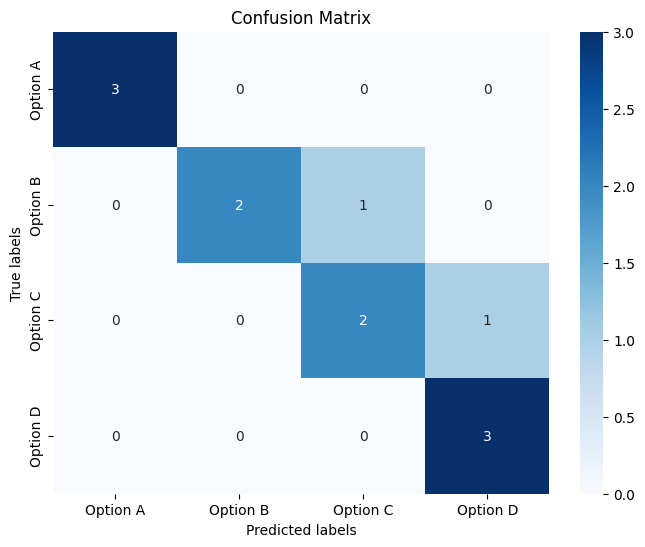

In [19]:
show_classification_metrics(trues, preds)

### Text Generation Metrics

In [20]:
show_text_generation_metrics(trues, preds)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




BLEU-1         =  0.94444
BLEU-2         =  0.92956
BLEU-3         =  0.75522
BLEU-4         =  0.67880

ROUGE-1        =  0.91667
ROUGE-2        =  0.83333
ROUGE-L        =  0.91667

BERT Precision =  0.95879
BERT Recall    =  0.95880
BERT F1 Score  =  0.95886


## Evaluation using T5 WITHOUT Fine-tuning

In [21]:
t5_model = T5ForConditionalGeneration.from_pretrained(base_t5_path).to(device)

In [22]:
preds = []
trues = []
for i, q in enumerate(eval_questions):
    print(f'========================= QUESTION {i+1:>2} / {len(eval_questions)} =========================')

    question_str = generate_question(q)
    print(question_str, end='\n\n')

    model_ans = rag(q, loaded_df, bert_model, bert_tokenizer, t5_model, t5_tokenizer, k)
    print(f"Model's output =  \"{model_ans}\"")

    correct_ans = f"Answer: {opt_idx2str[q['cop']]}"
    print(f"Correct output =  \"{correct_ans}\"", end='\n\n')
    
    preds.append(model_ans)
    trues.append(correct_ans)

========================= QUESTION  1 / 12 =========================
What is the term for the active searching for unrecognized problems in apparently healthy individuals using quick tests?
A) Vaccination
B) Screening
C) Monitoring
D) Diagnosis

Model's output =  "Screening is the"
Correct output =  "Answer: B"

========================= QUESTION  2 / 12 =========================
Which of the following causes a decrease in ESR?
A) Sickle cell anaemia
B) Inflammation
C) COVID-19
D) Pregnancy

Model's output =  "Ans. ("
Correct output =  "Answer: A"

========================= QUESTION  3 / 12 =========================
Which option could be identified using the cephalic index?
A) Blood type
B) Sex
C) Hair color
D) Race

Model's output =  "Cephalic index"
Correct output =  "Answer: D"

========================= QUESTION  4 / 12 =========================
In which case is a magistrate inquest NOT required?
A) Death in police custody
B) Death in police firing
C) Death by suicide
D) Death in p

### Classification Metrics

Accuracy        =  0.00%
Macro F1-score  =  0.00%
Micro F1-score  =  0.00%
Macro Precision =  0.00%
Macro Recall    =  0.00%


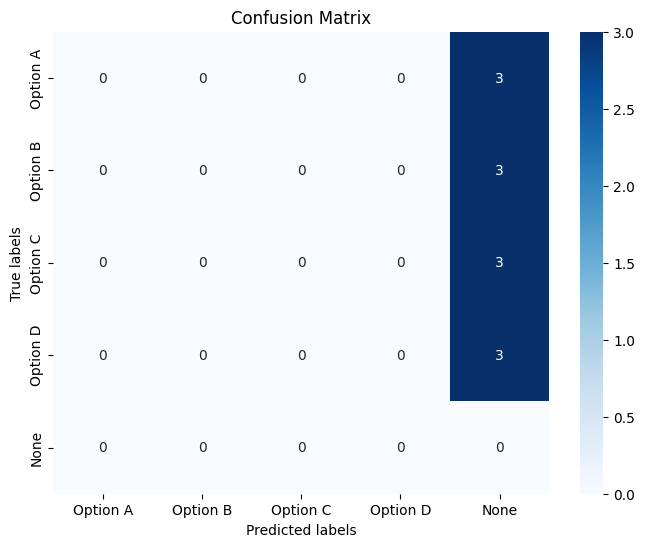

In [23]:
show_classification_metrics(trues, preds)

### Text Generation Metrics

In [24]:
show_text_generation_metrics(trues, preds)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




BLEU-1         =  0.03066
BLEU-2         =  0.02168
BLEU-3         =  0.01940
BLEU-4         =  0.01823

ROUGE-1        =  0.05556
ROUGE-2        =  0.00000
ROUGE-L        =  0.05556

BERT Precision =  0.02311
BERT Recall    =  -0.00194
BERT F1 Score  =  0.00810
